### Ejecución Random Forest

Librerias

In [71]:
import numpy as np
import pandas as pd
import joblib

#Librerias del modelo

from sklearn.ensemble import RandomForestRegressor
#Escalar Variables
from sklearn.preprocessing import MinMaxScaler
#import statsmodels.api as sm
import math
#evaluacion de variables
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

Se importa nuestro DataSet Limpio

In [72]:
dataSetCalidadAire = pd.read_csv("data/stage/dataSetLimpio4.csv")

dataSetCalidadAire.head(3)

,anio,mes,dia,hora,pm25,festivo,temperatura,humedad,presion,p1,...,dia_semana_Inicio Semana,dia_semana_Media semana,estacion_Estacion Aranjuez,estacion_Estacion Belen,estacion_Estacion Caldas,estacion_Estacion Itagui,franja_horaria_Madrugada,franja_horaria_Mañana,franja_horaria_Noche,franja_horaria_Tarde
0,2024,1,1,0,16,1,20,84,0,0,...,1,0,0,0,0,1,1,0,0,0
1,2024,1,1,2,47,1,18,82,0,0,...,1,0,0,0,0,1,1,0,0,0
2,2024,1,1,6,39,1,17,84,0,0,...,1,0,0,0,0,1,0,1,0,0


In [73]:
columnasEliminar = ['temperatura']
X = dataSetCalidadAire.drop(columns = columnasEliminar)
y = dataSetCalidadAire['temperatura']

In [74]:
# División de los datos
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.7, #70 % de nuestros datos en entrenamiento
    random_state=1234,
    shuffle=True
)

In [75]:
columnasModelo = X.columns.tolist()
columnasModelo 
# Llamamos nuestro scaler ya guardado
scaler = joblib.load("data/stage/estandarizacionDataSet2.pkl")
# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_train[columnasModelo] = scaler.fit_transform(X_train[columnasModelo])
X_test[columnasModelo] = scaler.transform(X_test[columnasModelo])

X_train[columnasModelo].head(3)

,anio,mes,dia,hora,pm25,festivo,humedad,presion,p1,velocidad_prom,...,dia_semana_Inicio Semana,dia_semana_Media semana,estacion_Estacion Aranjuez,estacion_Estacion Belen,estacion_Estacion Caldas,estacion_Estacion Itagui,franja_horaria_Madrugada,franja_horaria_Mañana,franja_horaria_Noche,franja_horaria_Tarde
10479,0.0000,0.0000,0.8333,0.2609,0.7143,0.0000,0.7209,0.9953,0.0000,0.0000,...,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
18821,0.0000,0.8750,0.2667,0.9130,0.1837,0.0000,0.6860,0.9953,0.0000,0.0000,...,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
14028,0.0000,0.7500,0.2667,0.3913,0.2245,0.0000,0.5000,0.9953,0.0000,0.2000,...,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


In [76]:
# Creación del modelo
# ==============================================================================
modelRF = RandomForestRegressor(
            n_estimators = 25,
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = 'sqrt',
            oob_score    = False,   #out-of-bag samples
            n_jobs       = -1,
            random_state = 123
         )


# Entrenamiento del modelo
# ==============================================================================
modelRF.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=25, n_jobs=-1,
                      random_state=123)

In [77]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelRF.predict(X = X_test)

rmse = mean_squared_error(y_true  = y_test, y_pred  = predicciones, squared = False)
print(f"El error (rmse) de test es: {rmse}")

r2 = r2_score(y_test, predicciones)
print(f"El error (r2) de test es: {r2}")

El error (rmse) de test es: 0.8886711529954363
El error (r2) de test es: 0.945761247426132


In [78]:
# Error de train del modelo inicial
# ==============================================================================
predicciones = modelRF.predict(X = X_train)

rmse = mean_squared_error(y_true  = y_train, y_pred  = predicciones, squared = False)
print(f"El error (rmse) de train es: {rmse}")

r2 = r2_score(y_train, predicciones)
print(f"El error (r2) de train es: {r2}")

El error (rmse) de train es: 0.3591652908364611
El error (r2) de train es: 0.990961886264289


In [79]:
len(dataSetCalidadAire)

19447

proceso para encontrar los hiperparametros

In [80]:
X_Completo = X
y_Completo = y

# Se escalan los datos numéricos de entrada
X_Completo[columnasModelo] = scaler.fit_transform(X_Completo[columnasModelo])

Valor óptimo de n_estimators(árboles): 96


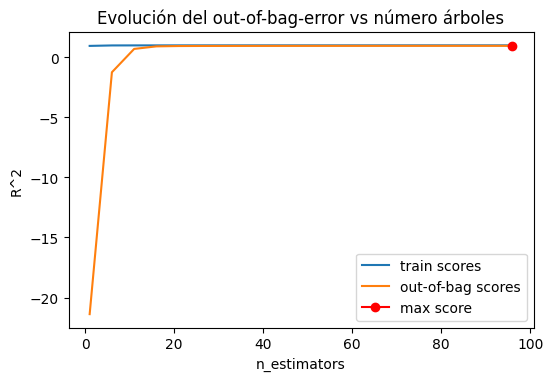

In [81]:
# Validación empleando el Out-of-Bag error : 

# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 100, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.

for n_estimators in estimator_range:
    
    modelRF = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error', #mean squared error
                max_depth    = None,
                max_features = 'sqrt',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelRF.fit(X_Completo, y_Completo)
    train_scores.append(modelRF.score(X_Completo, y_Completo))
    oob_scores.append(modelRF.oob_score_)
    


# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators(árboles): {estimator_range[np.argmax(oob_scores)]}")

Valor óptimo de n_estimators: 36


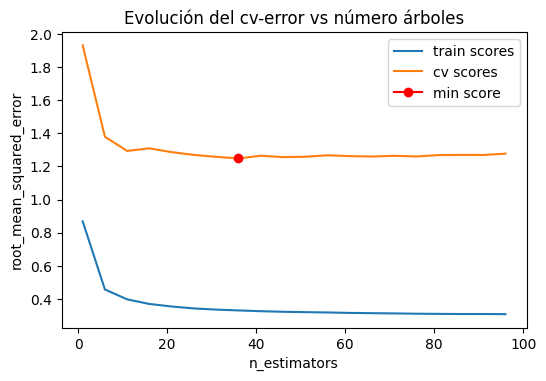

In [82]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 100, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
    
    modelRF = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error', #mean squared error: mse
                max_depth    = None,
                max_features = 'sqrt',
                oob_score    = False,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelRF.fit(X_Completo, y_Completo)
    predicciones = modelRF.predict(X = X_Completo)
    rmse = mean_squared_error(
            y_true  = y_Completo,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelRF,
                X         = X_Completo,
                y         = y_Completo,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

Valor óptimo de max_features: 19


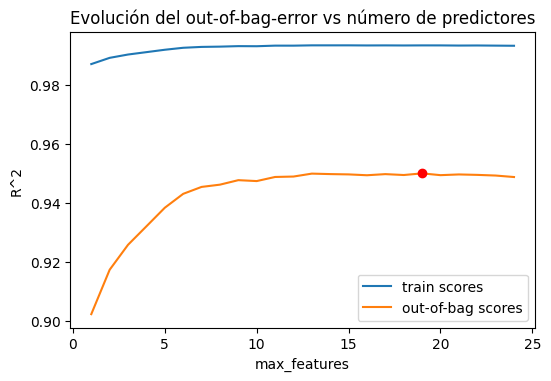

In [83]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
max_features_range = range(1, X_Completo.shape[1] + 1, 1) #X_train.shape[1] = total de características


# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de Out-of-Bag.
for max_features in max_features_range:
    modelRF = RandomForestRegressor(
                n_estimators = 20,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelRF.fit(X_Completo, y_Completo)
    train_scores.append(modelRF.score(X_Completo, y_Completo))
    oob_scores.append(modelRF.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend()
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

Valor óptimo de max_features: 11


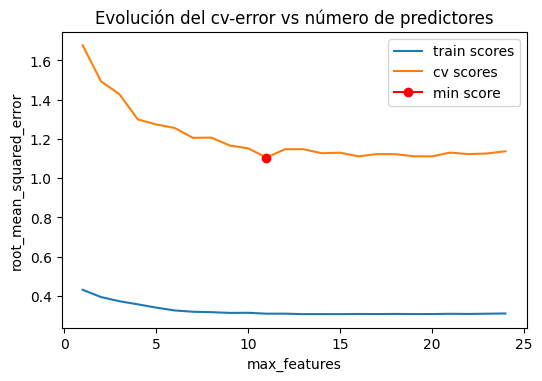

In [84]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
max_features_range = range(1, X_Completo.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de k-cross-validation.
for max_features in max_features_range:
    
    modelRF = RandomForestRegressor(
                n_estimators = 20,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelRF.fit(X_Completo, y_Completo)
    predicciones = modelRF.predict(X = X_Completo)
    rmse = mean_squared_error(
            y_true  = y_Completo,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelRF,
                X         = X_Completo,
                y         = y_Completo,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, cv_scores, label="cv scores")
ax.plot(max_features_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend()
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(cv_scores)]}")

In [85]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [15, 20, 25],
                 'max_features': [7, 9, 11, 12],
                 'max_depth'   : [3, 10, 20]
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:
    
    modelRF = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelRF.fit(X_Completo, y_Completo)
    
    resultados['params'].append(params)
    resultados['oob_r2'].append(modelRF.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(5)

Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 15} ✓
Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 20} ✓
Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 25} ✓
Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 15} ✓
Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 20} ✓
Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 25} ✓
Modelo: {'max_depth': 3, 'max_features': 11, 'n_estimators': 15} ✓
Modelo: {'max_depth': 3, 'max_features': 11, 'n_estimators': 20} ✓
Modelo: {'max_depth': 3, 'max_features': 11, 'n_estimators': 25} ✓
Modelo: {'max_depth': 3, 'max_features': 12, 'n_estimators': 15} ✓
Modelo: {'max_depth': 3, 'max_features': 12, 'n_estimators': 20} ✓
Modelo: {'max_depth': 3, 'max_features': 12, 'n_estimators': 25} ✓
Modelo: {'max_depth': 10, 'max_features': 7, 'n_estimators': 15} ✓
Modelo: {'max_depth': 10, 'max_features': 7, 'n_estimators': 20} ✓
Modelo: {'max_depth': 10, 'max_features': 7, 'n_estimators': 25} ✓
M

,oob_r2,max_depth,max_features,n_estimators
35,0.9548,20,12,25
32,0.9546,20,11,25
29,0.9535,20,9,25
26,0.9514,20,7,25
34,0.9489,20,12,20


In [86]:
# Mejores hiperparámetros por out-of-bag error
# ==============================================================================
print("--------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-r2)")
print("--------------------------------------------")
print(resultados.iloc[0,:]['oob_r2'], "R2")

--------------------------------------------
Mejores hiperparámetros encontrados (oob-r2)
--------------------------------------------
0.9547748591219092 R2


In [87]:
#Se entrena el modelo con múltiples hiperparámetros buscando el mejor


# Definir el modelo AdaBoostRegressor
modelRF = RandomForestRegressor(random_state = 123)


CV = 10


parameters =  {
                'n_estimators': [15, 20, 25],
                'max_features': [9, 10, 11, 12],
                'max_depth'   : [3, 10, 20]
                }

grid_RF = GridSearchCV(
                    estimator  = modelRF,
                    param_grid = parameters,
                    scoring    =  'r2',         #'neg_root_mean_squared_error',
                    n_jobs     = - 1,
                    cv         = CV, 
                    refit      = True,
                    verbose    = 3,
                    return_train_score = True
                   )

grid_RF.fit(X = X_Completo, y = y_Completo)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': [3, 10, 20],
                         'max_features': [9, 10, 11, 12],
                         'n_estimators': [15, 20, 25]},
             return_train_score=True, scoring='r2', verbose=3)

In [88]:
# Resultados
resultados = pd.DataFrame(grid_RF.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
35,20,12,25,0.9193,0.0162,0.9935,0.0002
32,20,11,25,0.9192,0.0156,0.9934,0.0002
31,20,11,20,0.9189,0.0159,0.9931,0.0002
34,20,12,20,0.9188,0.0165,0.9932,0.0002


In [89]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)


# Obtener los resultados del grid search
results_grid_RF = pd.DataFrame(grid_RF.cv_results_)


# Seleccionar las columnas deseadas
columns_grid_RF = ['param_max_depth']  + \
                    ['param_max_features']  + \
                    ['param_n_estimators']  + \
                    ['mean_test_score', 'std_test_score']  + \
                    [f'split{i}_test_score' for i in range(CV)]

# Filtrar y mostrar los resultados
results_grid_RF_filtered = results_grid_RF[columns_grid_RF]

# Crear la columna scoreWithStd: f1 / std
results_grid_RF_filtered['scoreWithStd'] = results_grid_RF_filtered.apply(
    lambda row: row['mean_test_score'] / row['std_test_score'] if row['std_test_score'] != 0 else 0,
    axis=1
)

# Encuentra el índice del máximo valor en la columna scoreWithStd
indice_max_scoreWithStd = results_grid_RF_filtered['scoreWithStd'].idxmax()

# Mostrar los scores promedios por cada parámetro
results_grid_RF_filtered[['param_max_depth', 'param_max_features','param_n_estimators', 'mean_test_score', 'std_test_score', 'scoreWithStd']]


,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,scoreWithStd
0,3,9,15,0.7241,0.1064,6.8056
1,3,9,20,0.7196,0.1095,6.5692
2,3,9,25,0.7274,0.1093,6.6573
3,3,10,15,0.7418,0.1005,7.3849
4,3,10,20,0.7315,0.1071,6.8318
5,3,10,25,0.7380,0.1031,7.1605
6,3,11,15,0.7621,0.0928,8.2168
7,3,11,20,0.7545,0.0916,8.2397
8,3,11,25,0.7580,0.0883,8.5873
9,3,12,15,0.7607,0.0879,8.6567


In [90]:
# Se identifican los mejores hiperparámetros
best_params = grid_RF.best_params_
print('Best Parameters : ',best_params)

Best Parameters :  {'max_depth': 20, 'max_features': 12, 'n_estimators': 25}


In [91]:
# Top 3 de los mejores scores
results_grid_RF_filtered.sort_values(by='scoreWithStd', ascending=False).head(3)[
    ['param_max_depth', 'param_max_features','param_n_estimators', 'mean_test_score', 'std_test_score', 'scoreWithStd']]

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,scoreWithStd
16,10,10,20,0.9145,0.0144,63.4797
17,10,10,25,0.9154,0.0147,62.4784
15,10,10,15,0.9136,0.0148,61.5786


In [92]:
# Seleccionar el registro correspondiente al índice máximo
registro_max_scoreWithStd = results_grid_RF_filtered.loc[indice_max_scoreWithStd]

registro_max_scoreWithStd.transpose()

param_max_depth      10.0000
param_max_features   10.0000
param_n_estimators   20.0000
mean_test_score       0.9145
std_test_score        0.0144
split0_test_score     0.9066
split1_test_score     0.9083
split2_test_score     0.9163
split3_test_score     0.8874
split4_test_score     0.9121
split5_test_score     0.9286
split6_test_score     0.9263
split7_test_score     0.9430
split8_test_score     0.9101
split9_test_score     0.9067
scoreWithStd         63.4797
Name: 16, dtype: float64

In [93]:
results_grid_RF_filtered.loc[indice_max_scoreWithStd]['mean_test_score']

np.float64(0.9145439263650349)

In [94]:
# Se crea un modelo árbol de decisión con los mejores hiperparámetros 
modelRF = RandomForestRegressor( max_depth = int(results_grid_RF_filtered.loc[indice_max_scoreWithStd]["param_max_depth"])
                               , max_features = int(results_grid_RF_filtered.loc[indice_max_scoreWithStd]["param_max_features"])
                               , n_estimators = int(results_grid_RF_filtered.loc[indice_max_scoreWithStd]["param_n_estimators"])
                               , random_state = 1234)


#Se entrena el modelo con los datos completos
modelRF.fit(X_Completo, y_Completo)

RandomForestRegressor(max_depth=10, max_features=10, n_estimators=20,
                      random_state=1234)

In [95]:
importancia_predictores = pd.DataFrame(
                            {'predictor': dataSetCalidadAire.drop(columns = "pm25").columns,
                             'importancia': modelRF.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
6,humedad,0.4384
23,franja_horaria_Tarde,0.1655
3,hora,0.1402
18,estacion_Estacion Caldas,0.1215
7,presion,0.0420
20,franja_horaria_Madrugada,0.0193
10,velocidad_max,0.0179
17,estacion_Estacion Belen,0.0094
1,mes,0.0082
11,direccion_prom,0.0080
